In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
from torch import nn 
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import glob 
from random import sample

(450, 600, 3)


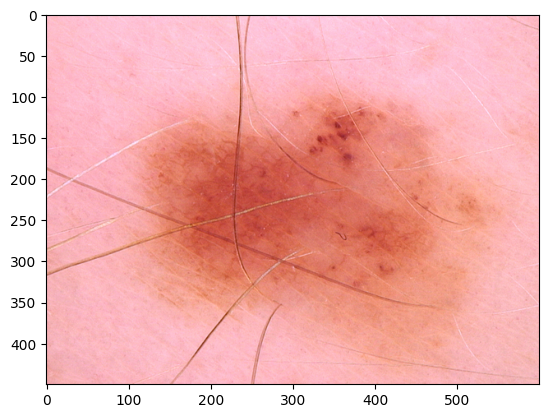

In [3]:
img =cv.imread("/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024872.jpg")

print(img.shape)
plt.imshow(img[...,::-1])


In [5]:
img_path_list = glob.glob("/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/*")
print(len(img_path_list))

5000


In [6]:
img_path_sample=sample(img_path_list,9)

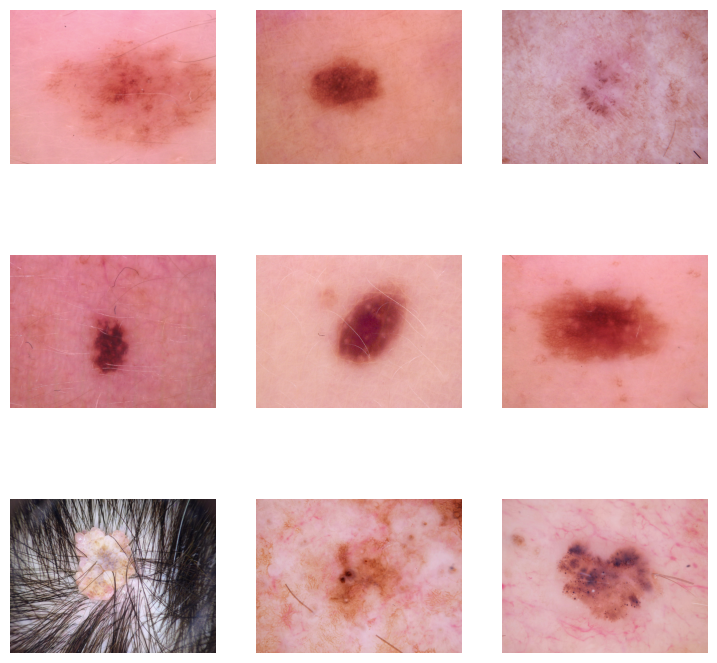

In [23]:
plt.figure(figsize=(9,9))
for i in range(9):
    plt.subplot(3,3,i+1)
    img = cv.imread(img_path_sample[i])
    plt.imshow(img[...,::-1])
#     plt.title(img.shape)
    plt.axis('off')

In [9]:
metadata = pd.read_csv("/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv")
print(metadata.columns)
metadata

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization'], dtype='object')


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [10]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [11]:
metadata = metadata.astype({'image_id': 'string'})
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  string 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(5), string(1)
memory usage: 547.8+ KB


In [12]:
f1 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/'
f2 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/'

In [13]:
metadata["path"] = metadata["image_id"].apply(lambda x : f1+x+'.jpg' if os.path.exists(f1+x+'.jpg') else f2+x+'.jpg')

In [14]:
metadata["exists"] = metadata["path"].apply(lambda x: os.path.exists(x))

In [15]:
metadata["exists"].value_counts()

exists
True    10015
Name: count, dtype: int64

In [16]:
metadata

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,exists
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,True
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,True
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,True
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,True
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,True
...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,True
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,True
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,True
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,True


In [17]:
metadata["dx"].value_counts()

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

Cases include a representative collection of all important diagnostic categories in the realm of pigmented lesions:
    Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec)
    basal cell carcinoma (bcc),
    benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl)
    dermatofibroma (df)
    melanoma (mel),
    melanocytic nevi (nv)
    and vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).

In [18]:
metadata2 = metadata[metadata.dx != "akiec"]

In [19]:
metadata2

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,exists
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,True
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,True
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,True
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,True
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,True
...,...,...,...,...,...,...,...,...,...
9683,HAM_0000102,ISIC_0031547,nv,consensus,20.0,male,back,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,True
9684,HAM_0000102,ISIC_0032221,nv,consensus,20.0,male,back,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,True
9685,HAM_0005314,ISIC_0030693,nv,consensus,40.0,male,neck,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,True
9686,HAM_0003322,ISIC_0031649,nv,consensus,50.0,female,face,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,True


In [20]:
metadata2["label"] = metadata["dx"].apply(lambda x: 1 if ((x == "mel") or (x == "bcc")) else 0 )
metadata2[metadata.dx == "mel"]

/tmp/ipykernel_34/2475341996.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata2["label"] = metadata["dx"].apply(lambda x: 1 if ((x == "mel") or (x == "bcc")) else 0 )
/tmp/ipykernel_34/2475341996.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metadata2[metadata.dx == "mel"]


,lesion_id,image_id,dx,dx_type,age,sex,localization,path,exists,label
1211,HAM_0000871,ISIC_0025964,mel,histo,40.0,female,chest,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,True,1
1212,HAM_0000871,ISIC_0030623,mel,histo,40.0,female,chest,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,True,1
1213,HAM_0000040,ISIC_0027190,mel,histo,80.0,male,upper extremity,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,True,1
1214,HAM_0005678,ISIC_0031023,mel,histo,60.0,male,chest,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,True,1
1215,HAM_0005678,ISIC_0028086,mel,histo,60.0,male,chest,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,True,1
...,...,...,...,...,...,...,...,...,...,...
2319,HAM_0001953,ISIC_0025611,mel,histo,65.0,male,back,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,True,1
6769,HAM_0002552,ISIC_0032985,mel,histo,25.0,male,upper extremity,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,True,1
8820,HAM_0002552,ISIC_0032936,mel,histo,25.0,male,upper extremity,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,True,1
8834,HAM_0002552,ISIC_0033232,mel,histo,25.0,male,upper extremity,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,True,1


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 9.444444444444438, '[0, 1]')

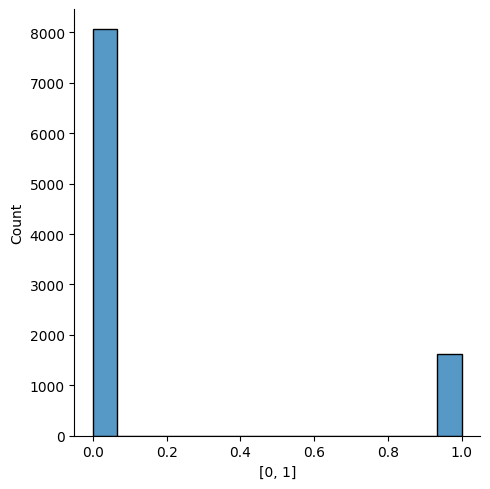

In [22]:
sns.displot(data = metadata2 ,x='label')
plt.xlabel([0,1])

In [ ]:
# metadata2.to_csv("metadata.csv")

## Split the dataset

In [ ]:
# metadata2.label.value_counts()

In [ ]:
# from sklearn.model_selection import train_test_split

# train ,test = train_test_split(metadata2,
#                                test_size= 0.2,
#                                random_state= 42,
#                                stratify=metadata2["label"]
#                               )
# test

In [ ]:
# train

In [ ]:
# train.label.value_counts()

In [ ]:
# from sklearn.utils import resample
# df1 = resample(train[train.label == 1],n_samples=3875,random_state=42,replace=True)
# df1

In [ ]:
# # df2 = train[train.label == 0]
# df2 = resample(train[train.label == 0],n_samples=3875,random_state=42,replace=False)
# bal_train = pd.concat([df1, df2], axis= 0)
# bal_train.reset_index(inplace=True,drop = True)
# bal_train

In [ ]:
# df2.image_id.duplicated().value_counts()

In [ ]:
# bal_train.label.value_counts()

In [ ]:
# bal_train.to_csv("balenced_train.csv")
# train.to_csv("train.csv")
# test.to_csv("test.csv")

In [ ]:
# test = pd.read_csv("/kaggle/input/resnet-50/test.csv")
# test.label.value_counts()

In [ ]:
# from sklearn.utils import resample
# dft1 = resample(test[test.label == 1],n_samples=969,random_state=42,replace=True)
# dft1

In [ ]:
# dft2 = train[train.label == 0]
# dft2 = resample(test[test.label == 0],n_samples=969,random_state=42,replace=False)
# bal_test = pd.concat([dft1, dft2], axis= 0)
# bal_test.reset_index(inplace=True,drop = True)
# bal_test

In [ ]:
# bal_test.label.value_counts()

In [ ]:
# bal_test.to_csv("balenced_test.csv")

## Create Custom Dataset

In [ ]:
transform_main = v2.Compose([
    
    v2.Resize(232,interpolation= v2.InterpolationMode.BILINEAR),
    v2.CenterCrop(224),
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),    #ToTensor()
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
transform_main

In [ ]:
from torchvision.transforms import v2
transform_aug = v2.Compose([
            v2.RandomRotation(45),
            v2.RandomHorizontalFlip(0.5)])
transform_aug

In [ ]:
train_transform = v2.Compose([transform_aug,transform_main])
train_transform

In [ ]:
class ham(Dataset):
    def __init__(self,csv_dir,transform = None):
        self.csv_dir = csv_dir
        self.datas = pd.read_csv(self.csv_dir)
        self.transform = transform
        
    def __getitem__(self,x):
        
        path = self.datas.path[x]
        img = Image.open(path)
        label = self.datas.label[x]
        label = torch.tensor(label, dtype = torch.float32)
        if self.transform:
            img = self.transform(img)
            
        return img, label
    
    def __len__(self):
        return len(self.datas)
    
train_dataset = ham("/kaggle/input/model-data/balenced_train.csv",train_transform)
test_dataset = ham("/kaggle/input/model-data/balenced_test.csv",transform_main)

In [ ]:
# img,label =train_dataset[150]
# print(label)
# print(len(train_dataset))
# plt.imshow(np.array(img))

In [ ]:
img,label =train_dataset[100]
label

In [ ]:
train_dataloader = DataLoader(dataset= train_dataset,
                              batch_size= 64,
                              shuffle= True
                              )
test_dataloader = DataLoader(dataset= test_dataset,
                              batch_size= 64,
                              shuffle= False
                              )

# Model

In [ ]:
# import requests
# request = requests.get("https://raw.githubusercontent.com/Woodman718/FixCaps/main/Module/HAM10000/model.py")
# with open("model.py","wb") as f:
#     f.write(request.content)

In [ ]:
Device = "cuda" if torch.cuda.is_available() else "cpu"
Device

In [ ]:
from torchvision.models import ResNet50_Weights,resnet50

weights = ResNet50_Weights.DEFAULT
model = resnet50(weights= weights).to(Device)

In [ ]:
from torchinfo import summary
summary(model=model,
        input_size=(1, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

In [ ]:
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.fc.in_features
# ResNet final fully connected layer
model.fc = nn.Linear(num_ftrs, 1)

In [ ]:
# a =torch.rand(1,3,224,224).to(Device)
# a

In [ ]:
# result = model(a)
# print(result)
# pred =torch.sigmoid(result)
# pred.squeeze(dim =0)

# Lets train the model

In [ ]:
from tqdm.auto import tqdm, trange

In [ ]:
from torchmetrics.classification import BinaryPrecision
from torchmetrics.classification import BinaryRecall
from torchmetrics.classification import BinaryAccuracy


In [ ]:
n = torch.tensor([])
d = torch.tensor([1,2,3,4])

In [ ]:
torch.cat((n,d))

In [ ]:
def train(model, device, train_loader, validation_loader, epochs, lr ,name):
    
#     percision = BinaryPrecision().to(device)
#     recall =BinaryRecall().to(device)
#     accuracy =BinaryAccuracy().to(device)
    
    model.to(device)
    loss_fn =  nn.BCEWithLogitsLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []
    
    with tqdm(range(epochs), unit='epoch') as tepochs:
        
        tepochs.set_description('Training')
        
        for epoch in tepochs:
            model.train()
            # Keeps track of the running loss
            running_loss = 0.
            correct, total = 0, 0
#             pred_list_train = torch.tensor([]).to(device)
#             target_list_train = torch.tensor([]).to(device)
            
            for data, target in train_loader:
                
                data, target = data.to(device), target.to(device)

                output = model(data).squeeze(dim =1)

                pred = torch.sigmoid(output)
                
#                 print(pre)
                
                pred = (pred > 0.5).float()
                
                optimizer.zero_grad()

                loss = loss_fn(output, target)

                loss.backward()

                optimizer.step()

                tepochs.set_postfix(loss=loss.item())
                running_loss += loss.item()  

#                 pred_list_train = torch.cat((pred_list_train,pred),dim=0)
#                 target_list_train = torch.cat((target_list_train,target),dim=0)
                # Get accuracy
#                 print(pred)
#                 print(target)
#                 print(pred_list_train)
#                 print(target_list_train)
                total += target.size(0)
                correct += (pred == target).sum().item()
            
            train_loss.append(running_loss / len(train_loader))  # Append the loss for this epoch (running loss divided by the number of batches e.g. len(train_loader))
            train_acc.append(correct / total)
#             train_percision = percision(pred_list_train,target_list_train)
#             train_recall = recall(pred_list_train,target_list_train)
#             train_accuracy = accuracy(pred_list_train,target_list_train)
        # Evaluate on validation data
            model.eval()
            with torch.inference_mode():
                running_loss = 0.
                correct, total = 0, 0

    #             pred_list_valid = torch.tensor([]).to(device)
    #             target_list_valid = torch.tensor([]).to(device)

                for data, target in validation_loader:

                    data, target = data.to(device), target.to(device)

                    optimizer.zero_grad()

                    output = model(data).squeeze(dim =1)

                    pred = torch.sigmoid(output)

                    pred = (pred > 0.5).float()

                    loss = loss_fn(output, target)

                    tepochs.set_postfix(loss=loss.item())

                    running_loss += loss.item()

    #                 pred_list_valid = torch.cat((pred_list_valid,pred),dim=0)
    #                 target_list_valid = torch.cat((target_list_valid,target),dim=0)
                    # Get accuracy
                    total += target.size(0)
                    correct += (pred == target).sum().item()

                validation_loss.append(running_loss / len(validation_loader))
                validation_acc.append(correct / total)
    #             valid_percision = percision(pred_list_valid,target_list_valid)
    #             valid_recall = recall(pred_list_valid,target_list_valid)
    #             valid_accuracy = accuracy(pred_list_valid,target_list_valid)
            print(f"Epoches: {epoch}")
            print(f"\nTrain loss: {train_loss[-1]:.5f} | Train acc: {train_acc[-1]:.5f} \n validation_loss: {validation_loss[-1]:.5f} | Test acc: {validation_acc[-1]:.5f}\n")
            if epoch % 5 == 0:
                torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
                }, f"./model_resnet50_{name}_e{epoch}.pth")
        
        return train_loss, train_acc , validation_loss, validation_acc


In [ ]:
train_loss1, train_acc1, validation_loss1, validation_acc1= train(model,Device,train_dataloader,test_dataloader,41, 0.0001, "freeze")

In [ ]:
for param in model.parameters():
    param.requires_grad = True
    
train_loss2, train_acc2, validation_loss2, validation_acc2= train(model,Device,train_dataloader,test_dataloader,11, 0.000001, "finetune")

In [ ]:
train_loss = train_loss1 + train_loss2
train_acc = train_acc1 + train_acc2
validation_loss = validation_loss1 + validation_loss2
validation_acc = validation_acc1 + validation_acc2

In [ ]:
def plot_loss_accuracy(train_loss, train_acc,
                       validation_loss, validation_acc):

    epochs = len(train_loss)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
    ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Epoch vs Loss')
    ax1.legend()

    ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
    ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Epoch vs Accuracy')
    ax2.legend()
    fig.set_size_inches(15.5, 5.5)

plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

In [ ]:
# !pip install grad-cam

In [ ]:
# from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
# from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
# from pytorch_grad_cam.utils.image import show_cam_on_image

In [ ]:
# Device

In [ ]:
# img , label = next(iter(train_dataloader2))
# img = img.to(Device)
# label = label.to(Device)
# label

In [ ]:
# viz_transform = v2.Compose([  
#     v2.Resize(232,interpolation= v2.InterpolationMode.BILINEAR),
#     v2.CenterCrop(224),
#     v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])])
# Norm = v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# test_viz = ham("/kaggle/working/test.csv",viz_transform )
# test_viz[1][0]

In [ ]:
# train_dataloader2 = DataLoader(dataset= train_dataset,
#                               batch_size= 1,
#                               shuffle= True
#                               )
# img , label = next(iter(train_dataloader2))
# img = img.to(Device)
# label = label.to(Device)

In [ ]:
# import random
# train_samples = []
# train_samples2 = []
# train_labels = []
# random_list = []
# train_pred=[]
# grayscale_cam =[]
# for i in range(0, 9):
#     random_list.append(random.randint(0, len(test_viz)))
#     sample, target = test_viz[random_list[-1]]
#     train_samples.append(sample)
#     model.eval()    
#     s= train_transform(sample).unsqueeze(dim=0).to(Device)
#     with torch.inference_mode():
#             y = model(s).round().int().item()
#     grayscale_cam.append(cam(input_tensor=s))
#     train_pred.append(y)
#     train_labels.append(target.int().item())

In [ ]:
# model.eval()
# target_layers = [model.layer4[-1]]
# cam = ScoreCAM(model=model, target_layers=target_layers)
# grayscale_cam = cam(input_tensor=img)
# # 
# # In this example grayscale_cam has only one image in the batch:
# # grayscale_cam = grayscale_cam[0, :]
# # visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

In [ ]:
# img[0]

In [ ]:
# plt.imshow(img[1].permute(1,2,0).cpu().numpy())

In [ ]:
# plt.imshow(grayscale_cam[1])

In [ ]:
# plt.imshow(img[1].permute(1,2,0).cpu().numpy())
# plt.contour(grayscale_cam[1])

In [ ]:
# img[1].cpu().numpy()

In [ ]:
# plt.countour(grayscale_cam[1])

In [ ]:
# show_cam_on_image(img[1].cpu().numpy(), grayscale_cam[1])